<a href="https://colab.research.google.com/github/Whitchurch/CNNTensorflowCode/blob/main/Team17_CNN_40Epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-GPU

     |████████████████████████████████| 458.3 MB 11 kB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install Tensorflow on Google Co-lab

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import csv 
from tensorflow import keras
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.layers import CuDNNLSTM # A superior LSTM that uses GPU more optimized for training.
from keras.layers import LSTM
from keras.models import Sequential

Steps to pre-process and load the data

In [4]:
os.chdir("drive/My Drive/Colab Notebooks")


In [5]:
ls

 Access_Local_directory.ipynb
'Copy of Untitled0.ipynb'
 ECGsignal2700.csv
 ECGsignal.csv
 ECGsignal_n2700.csv
 ECGsignal_n.csv
 ECGsignal_nwhite.csv
 Exercise_1_Cats_vs_Dogs_Question-FINAL.ipynb
 Exercise_2_Cats_vs_Dogs_using_augmentation_Question-FINAL.ipynb
 Exercise_3_Horses_vs_humans_using_Transfer_Learning_Question-FINAL.ipynb
 Exercise_4_Multi_class_classifier_Question-FINAL.ipynb
 FinalCNN_Beginner.ipynb
 Team17_CNN_LSTM.ipynb
 Untitled0.ipynb
 Untitled1.ipynb
 Untitled2.ipynb


In [6]:
#Read the clean signal
with open('ECGsignal2700.csv') as csv_file:
  csv_reader = csv.reader(csv_file)

  for ECGsignal in csv_reader:
    print(ECGsignal)
  print("Finished reading the file")

#Time to dissect the file read data's anatomy:
#Total number of items in the list:
len(ECGsignal)

#Convert the list to an array 
ECGsignal_arr = np.array(ECGsignal,dtype=float)

#Read the noisy signal
with open('ECGsignal_n2700.csv') as csv_file:
  csv_reader = csv.reader(csv_file)

  for ECGsignal_n in csv_reader:
    print(ECGsignal_n)
  print("Finished reading the file")

#Time to dissect the file read data's anatomy:
#Total number of items in the list:
len(ECGsignal_n)

#Convert the list to an array 
ECGsignal_n_arr = np.array(ECGsignal_n,dtype=float)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [7]:
tupleofdimensions = ECGsignal_arr.shape
num = tupleofdimensions[0]
Training_test_Split = 0.95  # Modify this line to control the Test-Train split

a=Training_test_Split*num;                                 
XTrain=ECGsignal_n_arr[0:int(a)];                  
YTrain=ECGsignal_arr[0:int(a)];
XTest=ECGsignal_n_arr[int(a):num];               
YTest=ECGsignal_arr[int(a):num];
scaling_factor = num/(5400000)
train_samples=(30*60*Training_test_Split/10)*scaling_factor;
test_samples =(30*60*(1-Training_test_Split)/10)*scaling_factor;

print(XTrain.shape)
print(XTest.shape)
print(int(train_samples))
print(int(test_samples))

(25650000,)
(1350000,)
855
45


In [8]:
print(YTrain.shape)
print(YTest.shape)

(25650000,)
(1350000,)


Break up the Train and Test data into 4D vectors for the Tensorflow CNN: Format is [Batch_size,Height,width,depth]

Reference:https://towardsdatascience.com/understanding-input-and-output-shapes-in-convolution-network-keras-f143923d56ca

In [9]:
XTrain_reshaped = np.reshape(XTrain,(int(train_samples),30000,1,1))
YTrain_reshaped = np.reshape(YTrain,(int(train_samples),30000))

XTest_reshaped = np.reshape(XTest,(int(test_samples),30000,1,1))
YTest_reshaped = np.reshape(YTest,(int(test_samples),30000))

print(XTest_reshaped.shape)
print(XTrain_reshaped.shape)





(45, 30000, 1, 1)
(855, 30000, 1, 1)


Start defining the layers of the CNN - From the De-noising paper

Model: "DNN_using_CNN_for_Denoising"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30000, 1, 36)      720       
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 30000, 1, 36)      144       
_________________________________________________________________
relu_1 (Dense)               (None, 30000, 1, 36)      1332      
_________________________________________________________________
avgpool_1 (AveragePooling2D) (None, 7500, 1, 36)       0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 7500, 1, 36)       24660     
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 7500, 1, 36)       144       
_________________________________________________________________
relu_2 (Dense)               (None, 750

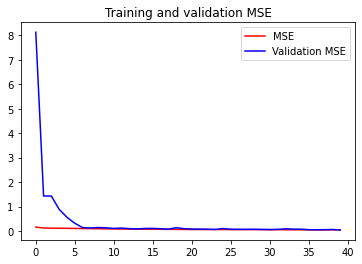

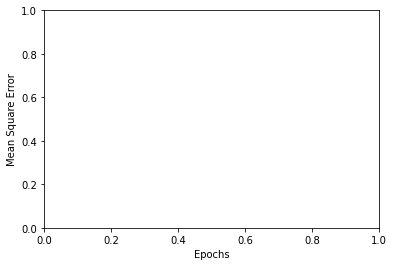

In [10]:
model = Sequential(name="DNN_using_CNN_for_Denoising")

# Convolution layers are used to extract the most prominent features of the input data.
#Layer 1:
#Conv-layer -> BatchNorm -> RELU-> AvdPooling
model.add(Conv2D(36, (19,1), input_shape=(30000,1,1),activation='relu',padding='SAME',strides=(1,1),name='conv_1')) 
model.add(BatchNormalization(name='batchnorm_1'))
model.add(Dense(units=36,activation='relu',name='relu_1'))
model.add(AveragePooling2D(pool_size=(2,1),strides=(4,1),name='avgpool_1'))

#Layer 2:
#Conv-layer -> BatchNorm -> RELU-> AvdPooling
model.add(Conv2D(36,(19,1),strides=(1,1),padding='SAME',name='conv_2'))
model.add(BatchNormalization(name='batchnorm_2'))
model.add(Dense(units=36,activation='relu',name='relu_2'))
model.add(AveragePooling2D(pool_size=(2,1),strides=(4,1),name='avgpool_2'))

#Layer 3:
#Conv-layer -> BatchNorm -> RELU-> AvdPooling
model.add(Conv2D(36,(19,1),strides=(1,1),padding='SAME',name='conv_3'))
model.add(BatchNormalization(name='batchnorm_3'))
model.add(Dense(units=36,activation='relu',name='relu_3'))
model.add(AveragePooling2D(pool_size=(2,1),strides=(4,1),name='avgpool_3'))

#Layer 4:
#Conv-layer -> BatchNorm -> RELU-> AvdPooling
model.add(Conv2D(36,(19,1),strides=(1,1),padding='SAME',name='conv_4'))
model.add(BatchNormalization(name='batchnorm_4'))
model.add(Dense(units=36,activation='relu',name='relu_4'))
model.add(AveragePooling2D(pool_size=(2,1),strides=(4,1),name='avgpool_4'))


#Layer 5:
#Conv-layer -> BatchNorm -> RELU-> AvdPooling
model.add(Conv2D(36,(19,1),strides=(1,1),padding='SAME',name='conv_5'))
model.add(BatchNormalization(name='batchnorm_5'))
model.add(Dense(units=36,activation='relu',name='relu_5'))
model.add(AveragePooling2D(pool_size=(2,1),strides=(4,1),name='avgpool_5'))


#Layer 6:
#Conv-layer -> BatchNorm -> RELU-> AvdPooling
model.add(Conv2D(36,(19,1),strides=(1,1),padding='SAME',name='conv_6'))
model.add(BatchNormalization(name='batchnorm_6'))
model.add(Dense(units=36,activation='relu',name='relu_6'))
model.add(AveragePooling2D(pool_size=(2,1),strides=(4,1),name='avgpool_6'))
model.add(Flatten())

#Now adding in the fully-connected dense layer: This will act on the data extracted from the CNN in the prior stages
model.add(Dense(units= 30000,activation=None,use_bias=True))
model.summary()

#Last layer of the FCN is only showing the inputsx weight.  
#Investigating to see, if the bias is used. even though model summary is not displaying it.
#weights, biases = model.layers[25].get_weights()
#print(len(weights))
#print(len(biases))

#Build the model, we follow the paper, using Adam optimizer, for speeding up gradient descent
#And RMS as the cost function, metric to optimize against.

#Compile the model
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mse'])

#Fit the model.
# Train the Model
#history = model.fit_generator(train_generator,validation_data = validation_generator, epochs = 10,steps_per_epoch = 1372, validation_steps = 350,verbose = 1 )
history = model.fit(XTrain_reshaped,YTrain_reshaped,epochs=40,verbose=2,validation_data=(XTest_reshaped,YTest_reshaped))

# Plot the chart for accuracy and loss on both training and validation
%matplotlib inline
import matplotlib.pyplot as plt
mse = history.history['mse']
val_mse = history.history['val_mse']


epochs = range(len(mse))

plt.plot(epochs, mse, 'r', label='MSE')
plt.plot(epochs, val_mse, 'b', label='Validation MSE')
plt.title('Training and validation MSE')
plt.legend()
plt.figure()
plt.ylabel('Mean Square Error')
plt.xlabel('Epochs')
plt.show()
                                    

In [11]:
#Save the model trained for 40 epochs.
model.save('CNN_40_Epochs.model')

INFO:tensorflow:Assets written to: CNN_40_Epochs.model/assets


CHARTS:

Sample Data plots:

OUTPUT EXPECTED ECG PLOT:

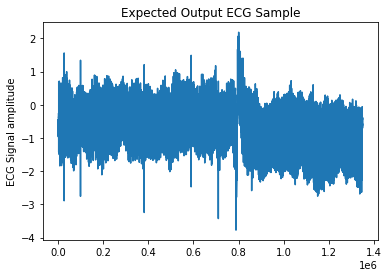

In [12]:
#Plot few samples of the output Test data:
plt.plot(YTest)
plt.title('Expected Output ECG Sample')
plt.ylabel('ECG Signal amplitude')
plt.show()


INPUT NOISY ECG PLOT:

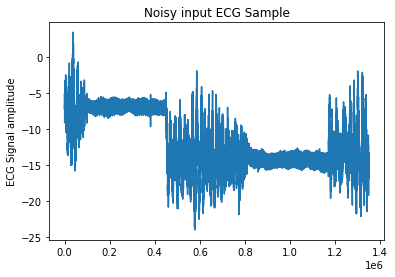

In [13]:
#Plot few samples of the input Test data:
plt.plot(XTest)
plt.title('Noisy input ECG Sample')
plt.ylabel('ECG Signal amplitude')
plt.show()

CNN DENOISED ECG SIGNAL PLOT:

In [14]:
#Do a prediction on the test data
prediction = model.predict(XTest_reshaped)
print(prediction)

[[-0.5724271  -0.6121886  -0.6090681  ... -0.59632987 -0.60083264
  -0.57739973]
 [-0.65034014 -0.6571244  -0.6457686  ... -0.64124817 -0.6125546
  -0.6424563 ]
 [-0.61572164 -0.64253205 -0.62179726 ... -0.6601122  -0.666089
  -0.65421236]
 ...
 [-0.4050451  -0.42697817 -0.3916728  ... -0.507714   -0.5076643
  -0.50347364]
 [-0.5067158  -0.53558934 -0.5378718  ... -0.43878192 -0.44770065
  -0.43234906]
 [-0.49196148 -0.50393724 -0.5081459  ... -0.43290693 -0.4395078
  -0.42405543]]


OUTPUT RESULT without reshaping:

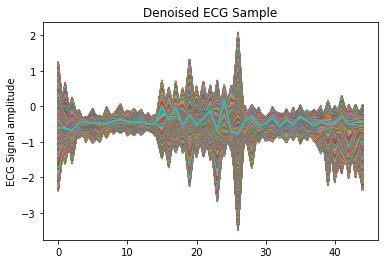

In [15]:
#Plot the denoised signal from the CNN
plt.plot(prediction)
plt.title('Denoised ECG Sample')
plt.ylabel('ECG Signal amplitude')
plt.show()

RESHAPE and Then OUTPUT SIGNAL:

(45, 30000)
(1350000,)


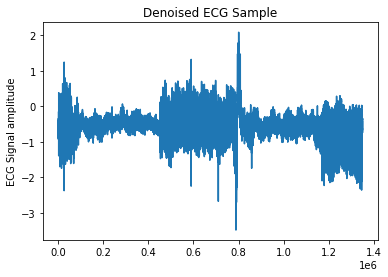

In [16]:
print(prediction.shape)
prediction_reshaped = np.reshape(prediction,XTest.shape)
print(prediction_reshaped.shape)

#Plot the reshaped output signal from the CNN
plt.plot(prediction_reshaped)
plt.title('Denoised ECG Sample')
plt.ylabel('ECG Signal amplitude')
plt.show()

Test the output for a single signal:

Text(0.5, 1.0, 'Plot a single input sample')

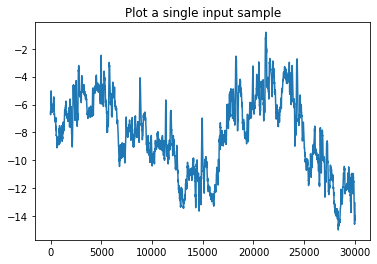

In [17]:
Xtest_1_Sample = XTest[0:30000]
plt.plot(Xtest_1_Sample)
plt.title('Plot a single input sample')

Plot a single Expecter Output Sample

Text(0.5, 1.0, 'Plot a single output sample')

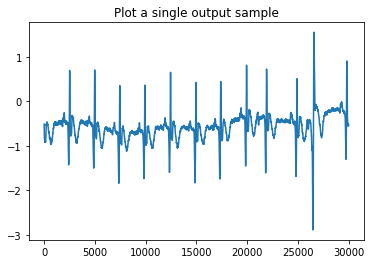

In [18]:
Ytest_1_Sample = YTest[0:30000]
plt.plot(Ytest_1_Sample)
plt.title('Plot a single output sample')

Plot the denoised Output Sample

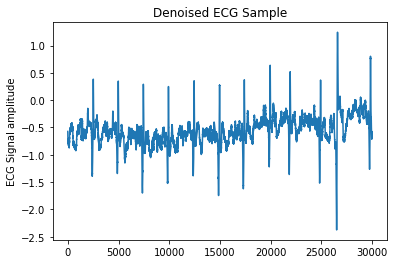

In [19]:
plt.plot(prediction_reshaped[0:30000])
plt.title('Denoised ECG Sample')
plt.ylabel('ECG Signal amplitude')
plt.show()

Helpful references:

1)This explains why last dense layer has no activation function:
  - we primarily do that if we are trying to accuractely do regression.

https://stats.stackexchange.com/questions/361066/what-is-the-point-of-having-a-dense-layer-in-a-neural-network-with-no-activation

2)This video shows how to implement a stacked LSTM model:
https://www.youtube.com/watch?v=BSpXCRTOLJA

3) This video shows the inner anatomy of an LSTM, primarily the sigmoid and Tanh, used for gating inside the LSTM:
https://www.youtube.com/watch?v=8HyCNIVRbSU&t=632s

4) The blogpost that references the video in 3. Is linked here:
https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

5) This is the link from Andrew NG, I studied to understand, why we use BatchNormalization in the CNN:
https://www.youtube.com/watch?v=nUUqwaxLnWs

6) Running on CPU vs GPU vs TPU???
https://serverguy.com/comparison/cpu-vs-gpu-vs-tpu/


